In [1]:
import torch
from torch import autograd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import copy
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
import cv2
import os

In [4]:
in_height = 120
in_width = 120
in_channels = 3

In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 4):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2,
                      bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=5, padding=2, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
)
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [6]:
def train(model, criterion, optimizer, lr_scheduler, dsets_loader, dset_sizes, lr = 0.001, num_epochs = 20):
    since = time.time()
    use_model = model
    best_acc = 0.0
    history = {
        x :[]
        for x in ['train','val']
    }
    
    for i in range(num_epochs):
        print('Epoch {}/{}'.format(i, num_epochs - 1))
        print('-'*10)
        for mode in ['train','val']:
            start = time.time()
            
            if mode == 'train':
                optimizer = lr_scheduler(optimizer, i, init_lr = lr)
                model.train(True)
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dsets_loader[mode]:
                inputs, labels = data
                inputs_, labels_ = Variable(inputs.cuda()), Variable(labels.cuda())
                
                optimizer.zero_grad()
                if mode == 'train':
                    outputs = model(inputs_)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels_)
                else:
                    outputs = model(inputs_)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels_)
                
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels_.data)
                
            epoch_loss = running_loss / dset_sizes[mode]
            epoch_acc = running_corrects / dset_sizes[mode]
            epoch_time = time.time() - start
            
            history_dict =  {
                'mode':mode,
                'epoch':i,
                'epoch_loss': epoch_loss,
                'epoch_accuracy': epoch_acc,
                'learing_rate':optimizer.state_dict()['param_groups'][0]['lr']
                
            }
            
            history[mode].append(history_dict)
            
            print('{} Loss: {:.4f} Acc:{:.4f} Time: {:.0f}m {:.0f}s'.format(mode, epoch_loss, epoch_acc, epoch_time//60, epoch_time%60))
            
            if mode == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        print()
    time_elapsed = time.time() - since
    
    print('Training completion in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best validation accuracy is {:.4f}'.format(best_acc))
    
    print('save mode')
    ##here I want to save the history of the process in order to debug
    with open('history.pickle','wb') as f:
        pickle.dump(history, f)
    
    return best_model, best_acc, history


In [7]:
#add scheduler to better control learning rate 
def exp_lr_scheduler(optimizer, epoch, init_lr = 0.001, lr_decay_epoch = 5):
    lr = init_lr * (0.9 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('Learning rate is changed to {}'.format(lr))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [8]:
#import mri_loader

In [9]:
train_file = './mri_imgs'
val_file = ''
##load data
#dset_loaders, dset_sizes, dset_classes = mri_loader.load_data(train_path=train_path, val_path=val_path)

In [10]:
net = AlexNet().cuda()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), weight_decay = 0.0005)
lr_scheduler = exp_lr_scheduler

In [12]:
lr = 0.001
#best_mode, best_acc = train(net, criterion, optimizer, lr_scheduler, dset_loaders, dset_sizes, lr, 40)

In [13]:
def load_data(train_path, val_path=None):
    if val_path is None:
        val_path = train_path
    train_transfrom = transforms.Compose([
        
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])

    val_transfrom = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])
    dsets = {
        'train': datasets.ImageFolder(train_path, train_transfrom),
        'val': datasets.ImageFolder(val_path, val_transfrom)
    }
    dset_loaders = {
        x: torch.utils.data.DataLoader(dsets[x], batch_size=20, shuffle=False, num_workers=1)
        for x in ['train', 'val']
    }
    dset_sizes = {
        x: len(dsets[x])
        for x in ['train', 'val']
    }
    
    dset_classes = dsets['train'].classes
    return dset_loaders, dset_sizes, dset_classes
        

In [14]:
dset_loaders, dset_sizes, dset_classes = load_data(train_path=train_file)

print(dset_sizes)
print(dset_classes)

{'train': 163, 'val': 163}
['label_0', 'label_1', 'label_2', 'label_3']


In [15]:
def load_data(train_path, val_path=None):
    if val_path is None:
        val_path = train_path
    train_transfrom = transforms.Compose([
        
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])

    val_transfrom = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])
    dsets = {
        'train': datasets.ImageFolder(train_path, train_transfrom),
        'val': datasets.ImageFolder(val_path, val_transfrom)
    }
    dset_loaders = {
        x: torch.utils.data.DataLoader(dsets[x], batch_size=20, shuffle=False, num_workers=1)
        for x in ['train', 'val']
    }
    dset_sizes = {
        x: len(dsets[x])
        for x in ['train', 'val']
    }
    
    dset_classes = dsets['train'].classes
    return dset_loaders, dset_sizes, dset_classes
        

    


In [16]:
best_model, best_acc, history = train(net, criterion, optimizer, lr_scheduler,dset_loaders, dset_sizes, lr, 120)


Epoch 0/119
----------
Learning rate is changed to 0.001
train Loss: 0.1741 Acc:0.2209 Time: 0m 1s
val Loss: 0.0762 Acc:0.3374 Time: 0m 0s

Epoch 1/119
----------
train Loss: 0.0751 Acc:0.4479 Time: 0m 1s
val Loss: 0.0990 Acc:0.2945 Time: 0m 0s

Epoch 2/119
----------
train Loss: 0.0884 Acc:0.2331 Time: 0m 1s
val Loss: 0.0761 Acc:0.3742 Time: 0m 0s

Epoch 3/119
----------
train Loss: 0.0809 Acc:0.2515 Time: 0m 1s
val Loss: 0.0699 Acc:0.4049 Time: 0m 0s

Epoch 4/119
----------
train Loss: 0.0703 Acc:0.5031 Time: 0m 1s
val Loss: 0.0708 Acc:0.4479 Time: 0m 0s

Epoch 5/119
----------
Learning rate is changed to 0.0009000000000000001
train Loss: 0.0658 Acc:0.5767 Time: 0m 1s
val Loss: 0.0601 Acc:0.5399 Time: 0m 0s

Epoch 6/119
----------
train Loss: 0.0631 Acc:0.5828 Time: 0m 1s
val Loss: 0.0651 Acc:0.4417 Time: 0m 0s

Epoch 7/119
----------
train Loss: 0.0608 Acc:0.6564 Time: 0m 1s
val Loss: 0.0666 Acc:0.4172 Time: 0m 0s

Epoch 8/119
----------
train Loss: 0.0584 Acc:0.6687 Time: 0m 1s
val

train Loss: 0.0031 Acc:1.0000 Time: 0m 1s
val Loss: 0.0911 Acc:0.4172 Time: 0m 0s

Epoch 71/119
----------
train Loss: 0.0034 Acc:0.9939 Time: 0m 1s
val Loss: 0.0934 Acc:0.3926 Time: 0m 0s

Epoch 72/119
----------
train Loss: 0.0036 Acc:1.0000 Time: 0m 1s
val Loss: 0.0921 Acc:0.3926 Time: 0m 0s

Epoch 73/119
----------
train Loss: 0.0036 Acc:1.0000 Time: 0m 1s
val Loss: 0.0881 Acc:0.4417 Time: 0m 0s

Epoch 74/119
----------
train Loss: 0.0038 Acc:0.9939 Time: 0m 1s
val Loss: 0.0851 Acc:0.4847 Time: 0m 0s

Epoch 75/119
----------
Learning rate is changed to 0.0002058911320946491
train Loss: 0.0039 Acc:1.0000 Time: 0m 1s
val Loss: 0.0836 Acc:0.4356 Time: 0m 0s

Epoch 76/119
----------
train Loss: 0.0030 Acc:1.0000 Time: 0m 1s
val Loss: 0.0829 Acc:0.4724 Time: 0m 0s

Epoch 77/119
----------
train Loss: 0.0032 Acc:1.0000 Time: 0m 1s
val Loss: 0.0811 Acc:0.4417 Time: 0m 0s

Epoch 78/119
----------
train Loss: 0.0035 Acc:0.9939 Time: 0m 1s
val Loss: 0.0830 Acc:0.4417 Time: 0m 0s

Epoch 79/11

In [17]:
train_epoch = []
train_loss = []
train_acc = []
learning_rate_used = []
for i in history['train']:
    train_epoch.append(i['epoch'])
    train_loss.append(i['epoch_loss'])
    train_acc.append(i['epoch_accuracy'])
    learning_rate_used.append(i['learing_rate'])

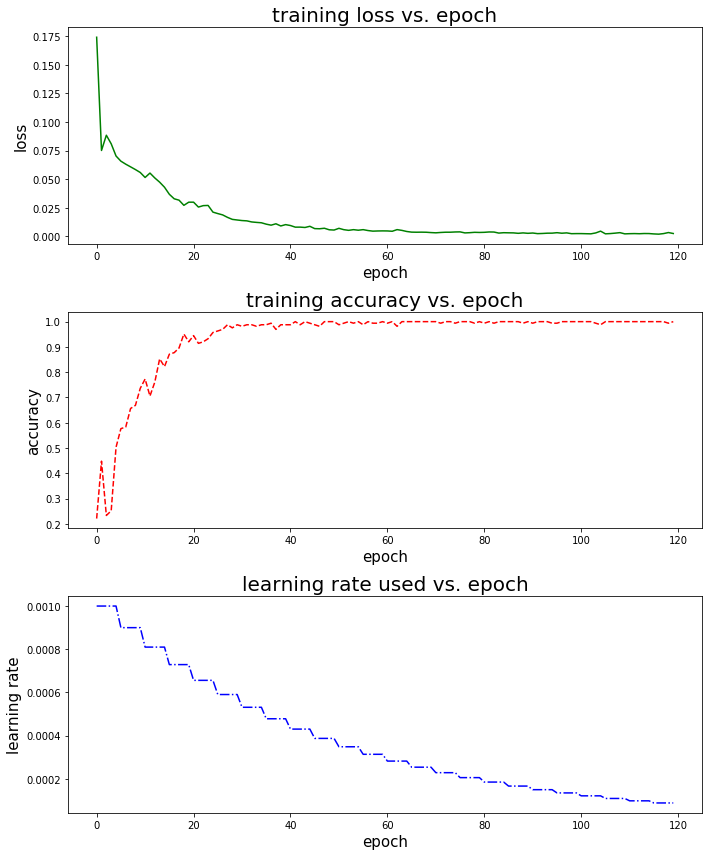

In [18]:
fig = plt.figure(figsize=(10, 12))

plt.subplot(311)
plt.plot(train_epoch, train_loss,'g-',linewidth = 1.5)
plt.title('training loss vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.tight_layout()
plt.subplot(312)
plt.plot(train_epoch, train_acc,'r--',linewidth = 1.5)
plt.title('training accuracy vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.tight_layout()
plt.subplot(313)
plt.plot(train_epoch, learning_rate_used,'b-.',linewidth = 1.5)
plt.title('learning rate used vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('learning rate', fontsize = 15)
plt.tight_layout()
fig.savefig('all_figures_alex.png')

In [19]:
val_epoch = []
val_acc = []
val_loss = []
for i in history['val']:
    val_epoch.append(i['epoch'])
    val_loss.append(i['epoch_loss'])
    val_acc.append(i['epoch_accuracy'])

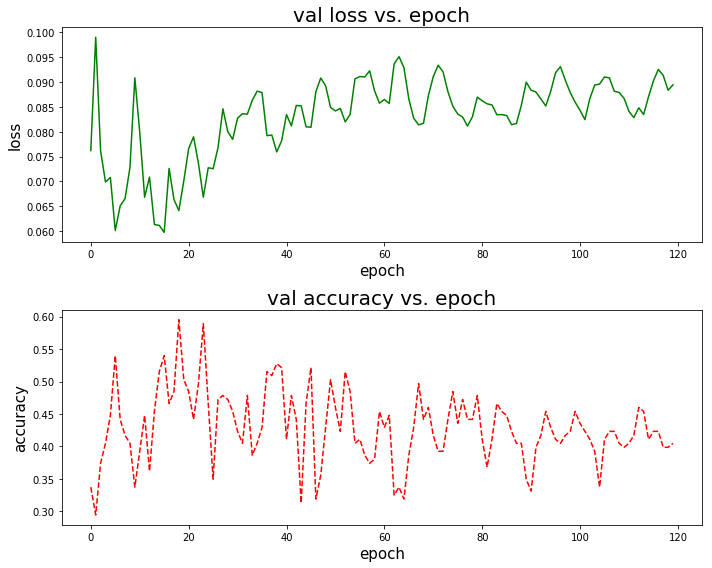

In [20]:
fig = plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.plot(val_epoch, val_loss,'g-',linewidth = 1.5)
plt.title('val loss vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.tight_layout()
plt.subplot(212)
plt.plot(val_epoch, val_acc,'r--',linewidth = 1.5)
plt.title('val accuracy vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.tight_layout()

fig.savefig('all_figures_val_alexnet.png')

In [21]:
print(best_model)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU (inplace)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): ReLU (inplace)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU (inplace)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): ReLU (inplace)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): MaxPool2d (size=(3, 3), 

In [22]:
sd = best_model.state_dict()

In [23]:
for key, value in sd.items():
    print(key)

features.0.weight
features.2.weight
features.2.bias
features.2.running_mean
features.2.running_var
features.4.weight
features.7.weight
features.7.bias
features.7.running_mean
features.7.running_var
features.8.weight
features.10.weight
features.10.bias
features.10.running_mean
features.10.running_var
features.11.weight
features.13.weight
features.13.bias
features.13.running_mean
features.13.running_var
features.14.weight
features.17.weight
features.17.bias
features.17.running_mean
features.17.running_var
classifier.0.weight
classifier.1.weight
classifier.1.bias
classifier.1.running_mean
classifier.1.running_var
classifier.4.weight
classifier.5.weight
classifier.5.bias
classifier.5.running_mean
classifier.5.running_var
classifier.8.weight
classifier.8.bias


In [24]:
pic_in, label = next(iter(dset_loaders['train']))
pic_one,label_one = pic_in[0],label[0]
pic_one_np = pic_one.numpy()
pic_one_np = np.expand_dims(pic_one_np,axis=0)
print(pic_one_np.shape)
label_one = torch.LongTensor([label[0]])
pic_one = torch.FloatTensor(pic_one_np)
#print(label)
print(pic_one)

(1, 3, 224, 224)

( 0 , 0 ,.,.) = 
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
           ...             ⋱             ...          
 -2.0152 -1.9980 -1.9809  ...  -2.1008 -2.1179 -2.1179
 -1.9809 -1.9638 -1.9295  ...  -2.1008 -2.1179 -2.1179
 -1.9638 -1.9467 -1.9124  ...  -2.1008 -2.1179 -2.1179

( 0 , 1 ,.,.) = 
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
           ...             ⋱             ...          
 -1.9307 -1.9132 -1.8957  ...  -2.0182 -2.0357 -2.0357
 -1.8957 -1.8782 -1.8431  ...  -2.0182 -2.0357 -2.0357
 -1.8782 -1.8606 -1.8256  ...  -2.0182 -2.0357 -2.0357

( 0 , 2 ,.,.) = 
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1.5922
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1.5922
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1

In [25]:
pic_in, label = Variable(pic_one.cuda()),Variable(label_one.cuda())

In [26]:
pic_in

Variable containing:
( 0 , 0 ,.,.) = 
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
 -2.1179 -2.1179 -2.1179  ...  -2.1179 -2.1179 -2.1179
           ...             ⋱             ...          
 -2.0152 -1.9980 -1.9809  ...  -2.1008 -2.1179 -2.1179
 -1.9809 -1.9638 -1.9295  ...  -2.1008 -2.1179 -2.1179
 -1.9638 -1.9467 -1.9124  ...  -2.1008 -2.1179 -2.1179

( 0 , 1 ,.,.) = 
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
 -2.0357 -2.0357 -2.0357  ...  -2.0357 -2.0357 -2.0357
           ...             ⋱             ...          
 -1.9307 -1.9132 -1.8957  ...  -2.0182 -2.0357 -2.0357
 -1.8957 -1.8782 -1.8431  ...  -2.0182 -2.0357 -2.0357
 -1.8782 -1.8606 -1.8256  ...  -2.0182 -2.0357 -2.0357

( 0 , 2 ,.,.) = 
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1.5922
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922 -1.5922
 -1.5922 -1.5922 -1.5922  ...  -1.5922 -1.5922

In [25]:
feature_blobs = []
def hook_feature(module, input, output):
    feature_blobs.append(output.data.cpu().numpy())

[[[  6.36593401e-01   1.46185958e+00   1.46185958e+00   9.74032581e-01
     4.31393415e-01   5.45710698e-02]
  [  6.36593401e-01   1.03778803e+00   1.03778803e+00   7.93871760e-01
     4.31393415e-01   3.86144310e-01]
  [  2.02416375e-01  -2.26346344e-01  -5.95272124e-01  -3.03309053e-01
     3.05072606e-01   3.86144310e-01]
  [ -1.23233989e-01  -3.48467976e-01  -5.95272124e-01  -4.50100124e-01
    -6.78694770e-02   1.09054744e-01]
  [  5.51310539e-01  -1.71989709e-01   1.82796836e-01   1.82796836e-01
    -4.52438027e-01  -3.94115180e-01]
  [  1.11730516e+00   1.97656369e+00   2.73577237e+00   2.62848616e+00
     1.46799278e+00   8.45956862e-01]]

 [[  7.66444057e-02  -7.73824990e-01  -7.73824990e-01  -2.94416428e-01
    -7.73824990e-01  -4.07604337e-01]
  [ -2.58789778e-01   6.00786358e-02  -5.12546599e-01  -2.22480357e-01
    -2.72531956e-01  -7.73824990e-01]
  [  1.08062811e-01   4.25274312e-01  -1.87700957e-01   1.16880514e-01
     1.16880514e-01  -3.59853625e-01]
  [  2.61067748e-

In [32]:
best_model._modules.get('features').register_forward_hook(hook_feature)

In [33]:
params = list(best_model.parameters())

In [34]:
print(params)

[Parameter containing:
(0 ,0 ,.,.) = 
 -8.0747e-03 -4.9054e-02 -3.9009e-02  ...  -5.8554e-02 -3.3211e-02 -4.9838e-02
 -5.3673e-02 -3.3703e-02  2.7667e-02  ...  -5.7314e-03  2.9005e-02 -4.8166e-02
  3.9745e-02 -3.2755e-02  1.0631e-02  ...   4.0317e-02  1.3747e-02  4.0800e-02
                 ...                   ⋱                   ...                
  3.2141e-02 -3.1875e-02  3.4959e-02  ...   1.7819e-02 -5.3370e-02 -3.5796e-02
 -5.2515e-02  3.4916e-03  1.9521e-02  ...  -1.4869e-02 -1.0881e-02 -4.4696e-02
 -4.9858e-02  3.3400e-02 -4.2828e-02  ...  -1.3904e-02 -3.5824e-02 -1.2510e-02

(0 ,1 ,.,.) = 
  4.9410e-02  2.5003e-02 -7.9459e-03  ...  -3.9253e-02  2.7022e-02 -3.7788e-03
  1.4904e-02 -5.3080e-02  2.3790e-02  ...  -7.5887e-03 -1.7650e-02 -1.4728e-02
  3.8045e-02  3.0705e-02  1.5201e-02  ...  -6.1246e-02  7.7839e-03 -5.4322e-02
                 ...                   ⋱                   ...                
 -1.2822e-02 -3.3181e-02 -4.5230e-02  ...   1.5227e-02  3.1530e-02  1.2517e-0

In [47]:
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
print(weight_softmax)
print(weight_softmax.shape)
weight_softmax[0]
snd_weight = np.squeeze(params[-3].data.cpu().numpy())
print(snd_weight.shape)
snd_weight = snd_weight[:,np.newaxis]
print(snd_weight.shape)


[[-0.01590703  0.01264616  0.01434551 ...,  0.0146488  -0.00976677
   0.01054867]
 [ 0.01998796  0.00954647  0.00180222 ..., -0.01206803 -0.01072765
   0.01223142]
 [ 0.00898552 -0.01595849  0.01118775 ..., -0.00836079  0.00197036
   0.00443072]]
(3, 4096)
(4096,)
(4096, 1)


In [48]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    #generate the class activation maps upsample to 256*256
    size_upsample = (256,256)
    h,w = feature_conv.shape
    #print(bz)
    #print(nc)
    print(h)
    print(w)
    output_cam = []
    for num,idx in enumerate(class_idx):
        
        cam = weight_softmax[idx].dot(feature_conv)
        cam = cam.reshape(h,w)
        cam = cam - np.min(cam)
        cam_img = cam/np.max(cam)
        cam_img = np.uint8(255*cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [49]:
logit = best_model(pic_in)

In [50]:
h_x = F.softmax(logit).data.cpu().squeeze()

In [51]:
probs, idx = h_x.sort(1, True)

In [52]:
print(idx)
idx_np = idx.numpy()
print(idx_np)
idx_array = idx_np[:,0]
idx_array = [int(i) for i in idx_array]
print(idx_array)


    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
    2     0     1
[torch.LongTensor of size 20x3]

[[2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [43]:
print(len(feature_blobs[0]))
print(feature_blobs[0])
print(len(feature_blobs[0][0]))

20
[[[[  6.36593401e-01   1.46185958e+00   1.46185958e+00   9.74032581e-01
      4.31393415e-01   5.45710698e-02]
   [  6.36593401e-01   1.03778803e+00   1.03778803e+00   7.93871760e-01
      4.31393415e-01   3.86144310e-01]
   [  2.02416375e-01  -2.26346344e-01  -5.95272124e-01  -3.03309053e-01
      3.05072606e-01   3.86144310e-01]
   [ -1.23233989e-01  -3.48467976e-01  -5.95272124e-01  -4.50100124e-01
     -6.78694770e-02   1.09054744e-01]
   [  5.51310539e-01  -1.71989709e-01   1.82796836e-01   1.82796836e-01
     -4.52438027e-01  -3.94115180e-01]
   [  1.11730516e+00   1.97656369e+00   2.73577237e+00   2.62848616e+00
      1.46799278e+00   8.45956862e-01]]

  [[  7.66444057e-02  -7.73824990e-01  -7.73824990e-01  -2.94416428e-01
     -7.73824990e-01  -4.07604337e-01]
   [ -2.58789778e-01   6.00786358e-02  -5.12546599e-01  -2.22480357e-01
     -2.72531956e-01  -7.73824990e-01]
   [  1.08062811e-01   4.25274312e-01  -1.87700957e-01   1.16880514e-01
      1.16880514e-01  -3.59853625e-

In [61]:
test_model = nn.Sequential(*list(best_model.children())[:-1])

In [62]:
print(test_model)

Sequential (
  (0): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU (inplace)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): ReLU (inplace)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU (inplace)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): ReLU (inplace)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): MaxPool2d (size=(3, 3), stri

In [63]:
test_model.eval()

Sequential (
  (0): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU (inplace)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): ReLU (inplace)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU (inplace)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): ReLU (inplace)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): MaxPool2d (size=(3, 3), stri

In [82]:
o = test_model(pic_in)

ValueError: Expected 4D tensor as input, got 3D tensor instead.

In [94]:
test = test_model(pic_in)

In [96]:
test_np = test.data.cpu().numpy()

In [97]:
print(test_np.shape)

(1, 256, 6, 6)


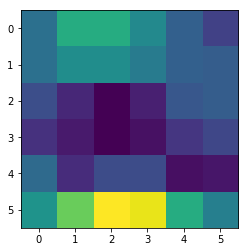

In [98]:
plt.imshow(test_np[0][0])

In [27]:

def save_class_activation_on_image(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    # Grayscale activation map
    path_to_file = os.path.join(file_name+'_Cam_Grayscale.jpg')
    cv2.imwrite(path_to_file, activation_map)
    # Heatmap of activation map
    activation_heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_HSV)
    path_to_file = os.path.join(file_name+'_Cam_Heatmap.jpg')
    cv2.imwrite(path_to_file, activation_heatmap)
    # Heatmap on picture
    org_img = cv2.resize(org_img, (224, 224))
    img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
    path_to_file = os.path.join(file_name+'_Cam_On_Image.jpg')
    cv2.imwrite(path_to_file, np.uint8(255 * img_with_heatmap))

In [28]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x

In [29]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_index=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_index is None:
            target_index = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).cuda().zero_()
        one_hot_output[0][target_index] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = cv2.resize(cam, (224, 224))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        return cam

In [30]:
grad_cam = GradCam(best_model, target_layer = 8)

In [31]:
test_img = cv2.imread('./mri_imgs/label_0/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_cor_110.jpg')
test_img_1 = cv2.resize(test_img,(224,224))

In [32]:
cam = grad_cam.generate_cam(pic_in,0)

In [33]:
save_class_activation_on_image(test_img_1, cam, 'alex_test_after_schiz')